## Assignment: Image recognition
- Alumno 1:
- Alumno 2:
- Alumno 3:

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/2DDPE2zHw5dbM3G](https://drive.upm.es/s/2DDPE2zHw5dbM3G)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import requests
import zipfile

url = 'https://drive.upm.es/s/2DDPE2zHw5dbM3G/download'
zip_name = 'dataset.zip'

r = requests.get(url, stream=True)
with open(zip_name, 'wb') as f:
    for chunk in r.iter_content(chunk_size=1024):
        f.write(chunk)

if os.path.getsize(zip_name) < 10000:
    print(f"ERREUR : Le fichier {zip_name} est trop petit. Le lien est invalide ou nécessite une connexion.")
else:
    with zipfile.ZipFile(zip_name, 'r') as z:
        z.extractall(".")

    target_file = 'xview_ann_train.json'
    found_path = None

    for root, dirs, files in os.walk("."):
        if target_file in files:
            found_path = os.path.join(root, target_file)
            break

    if found_path:
        print(f"SUCCÈS : Fichier trouvé à : {found_path}")

        import json
        json_file = found_path

        with open(json_file) as ifs:
            json_data = json.load(ifs)
        print("Base de données chargée avec succès !")

    else:
        print(f"ERREUR : {target_file} reste introuvable après extraction.")

SUCCÈS : Fichier trouvé à : ./xview_recognition/xview_ann_train.json
Base de données chargée avec succès !
SUCCÈS : Fichier trouvé à : ./xview_recognition/xview_ann_train.json
Base de données chargée avec succès !


In [2]:
import tensorflow as tf

# Vérifie la présence de processeurs graphiques
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Configuration pour ne pas allouer toute la mémoire d'un coup
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU activé : {len(gpus)} processeur(s) détecté(s)")
    except RuntimeError as e:
        print(e)
else:
    print("GPU non détecté. Activez l'accélérateur dans les réglages du notebook.")

GPU activé : 1 processeur(s) détecté(s)
GPU activé : 1 processeur(s) détecté(s)


In [3]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [4]:
categories = {0: 'Cargo plane', 1: 'Small car', 2: 'Bus', 3: 'Truck', 4: 'Motorboat', 5: 'Fishing vessel', 6: 'Dump truck', 7: 'Excavator', 8: 'Building', 9: 'Helipad', 10: 'Storage tank', 11: 'Shipping container', 12: 'Pylon'}

In [5]:
!pip install rasterio

In [6]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open('./xview_recognition/'+filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [7]:
import json

# Load database
json_file = './xview_recognition/xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [8]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)
labels = [img.objects[0].category for img in anns]

{'Cargo plane': 635, 'Small car': 3324, 'Bus': 1768, 'Truck': 2210, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 3594, 'Helipad': 111, 'Storage tank': 1469, 'Shipping container': 1523, 'Pylon': 312}


In [9]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True, stratify=labels)
print('Number of training images: ' + str(len(anns_train)))
print('Number of validation images: ' + str(len(anns_valid)))

Number of training images: 16871
Number of validation images: 1875


In [10]:
# Load architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Normalization
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras.optimizers import Nadam
import tensorflow as tf

#norm_layer = Normalization()

model = Sequential()
model.add(Input(shape=(32, 32, 3)))
#model.add(norm_layer)
model.add(Flatten())

# Layer 1
model.add(Dense(1024, kernel_initializer='he_normal'))
#model.add(BatchNormalization())
model.add(Activation('swish'))
#model.add(Dropout(0.4))

# Layer 2
model.add(Dense(1024, kernel_initializer='he_normal'))
#model.add(BatchNormalization())
model.add(Activation('swish'))
#model.add(Dropout(0.4))

# Layer 3
#model.add(Dense(256, kernel_initializer='he_normal'))
#model.add(BatchNormalization())
#model.add(Activation('swish'))
#model.add(Dropout(0.4))

# Output
model.add(Dense(len(categories)))
model.add(Activation('softmax'))

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=40 * (len(anns_train) // 32)
)

model.compile(
    optimizer=Nadam(learning_rate=lr_schedule, weight_decay=1e-4),
    loss=CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0),
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     3,146,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │        13,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 13)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,209,677 (16.06 MB)

 Trainable params: 4,209,677 (16.06 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
#from tensorflow.keras.optimizers import Adam
#
## Learning rate is changed to 0.001
#opt = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0)
#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
#reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=20, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, early_stop, terminate]

In [13]:
def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                img = load_geoimage(filename)
                # Convertir en tenseur Tensorflow pour le traitement
                img_tensor = tf.convert_to_tensor(img)
                # Convertir en float32 et normaliser entre 0 et 1
                img_tensor = tf.image.convert_image_dtype(img_tensor, tf.float32)
                # Redimensionnement via bicubic (+ précis)
                img_resized = tf.image.resize(img_tensor, [32, 32], method='bicubic')
                # On repasse en Numpy pour construire le batch
                images.append(img_resized.numpy())
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [14]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 128 # change to 32 to stabilize the gradients
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

In [15]:
import math
import numpy as np

print('Training model')
epochs = 100 # model still improving after 20 epochs -> stabilization
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model
Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.2904 - loss: 0.5005
Epoch 1: val_accuracy improved from -inf to 0.42720, saving model to model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 89s 649ms/step - accuracy: 0.2909 - loss: 0.4995 - val_accuracy: 0.4272 - val_loss: 0.2967
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.4563 - loss: 0.2718
Epoch 2: val_accuracy improved from 0.42720 to 0.43093, saving model to model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 73s 558ms/step - accuracy: 0.4564 - loss: 0.2718 - val_accuracy: 0.4309 - val_loss: 0.2857
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.4937 - loss: 0.2450
Epoch 3: val_accuracy improved from 0.43093 to 0.49440, saving model to model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 73s 554ms/step - accuracy: 0.4937 - loss: 0.2450 - val_accuracy: 0.4944 - val_loss: 0.2418
Epoch 4/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.5243 - loss: 0.2236
Epoch 4: val_accurac

#### Validation
Compute validation metrics.

In [16]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.colormaps['Blues'])
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show()

In [17]:
import numpy as np
import tensorflow as tf

model.load_weights('model.keras')
y_true, y_pred = [], []
all_images = []
temp_true_labels = []

print("Chargement des données de validation...")
for ann in anns_valid:
    # 1. Charger l'image brute
    image_raw = load_geoimage(ann.filename)

    # 2. Prétraitement IDENTIQUE à l'entraînement
    image_tensor = tf.convert_to_tensor(image_raw)
    image_tensor = tf.image.convert_image_dtype(image_tensor, tf.float32)
    # C'est cette ligne qui manquait :
    image_resized = tf.image.resize(image_tensor, [32, 32], method='bicubic')

    # Stocker pour chaque objet de l'image
    for obj_pred in ann.objects:
        all_images.append(image_resized.numpy())
        temp_true_labels.append(obj_pred.category)

if all_images:
    X_valid = np.array(all_images)
    print(f"Lancement de la prédiction sur {len(X_valid)} objets...")

    all_predictions = model.predict(X_valid, batch_size=64, verbose=1)

    category_names = list(categories.values())
    for i in range(len(all_predictions)):
        pred_category = category_names[np.argmax(all_predictions[i])]
        y_true.append(temp_true_labels[i])
        y_pred.append(pred_category)

Chargement des données de validation...
Lancement de la prédiction sur 1875 objets...
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


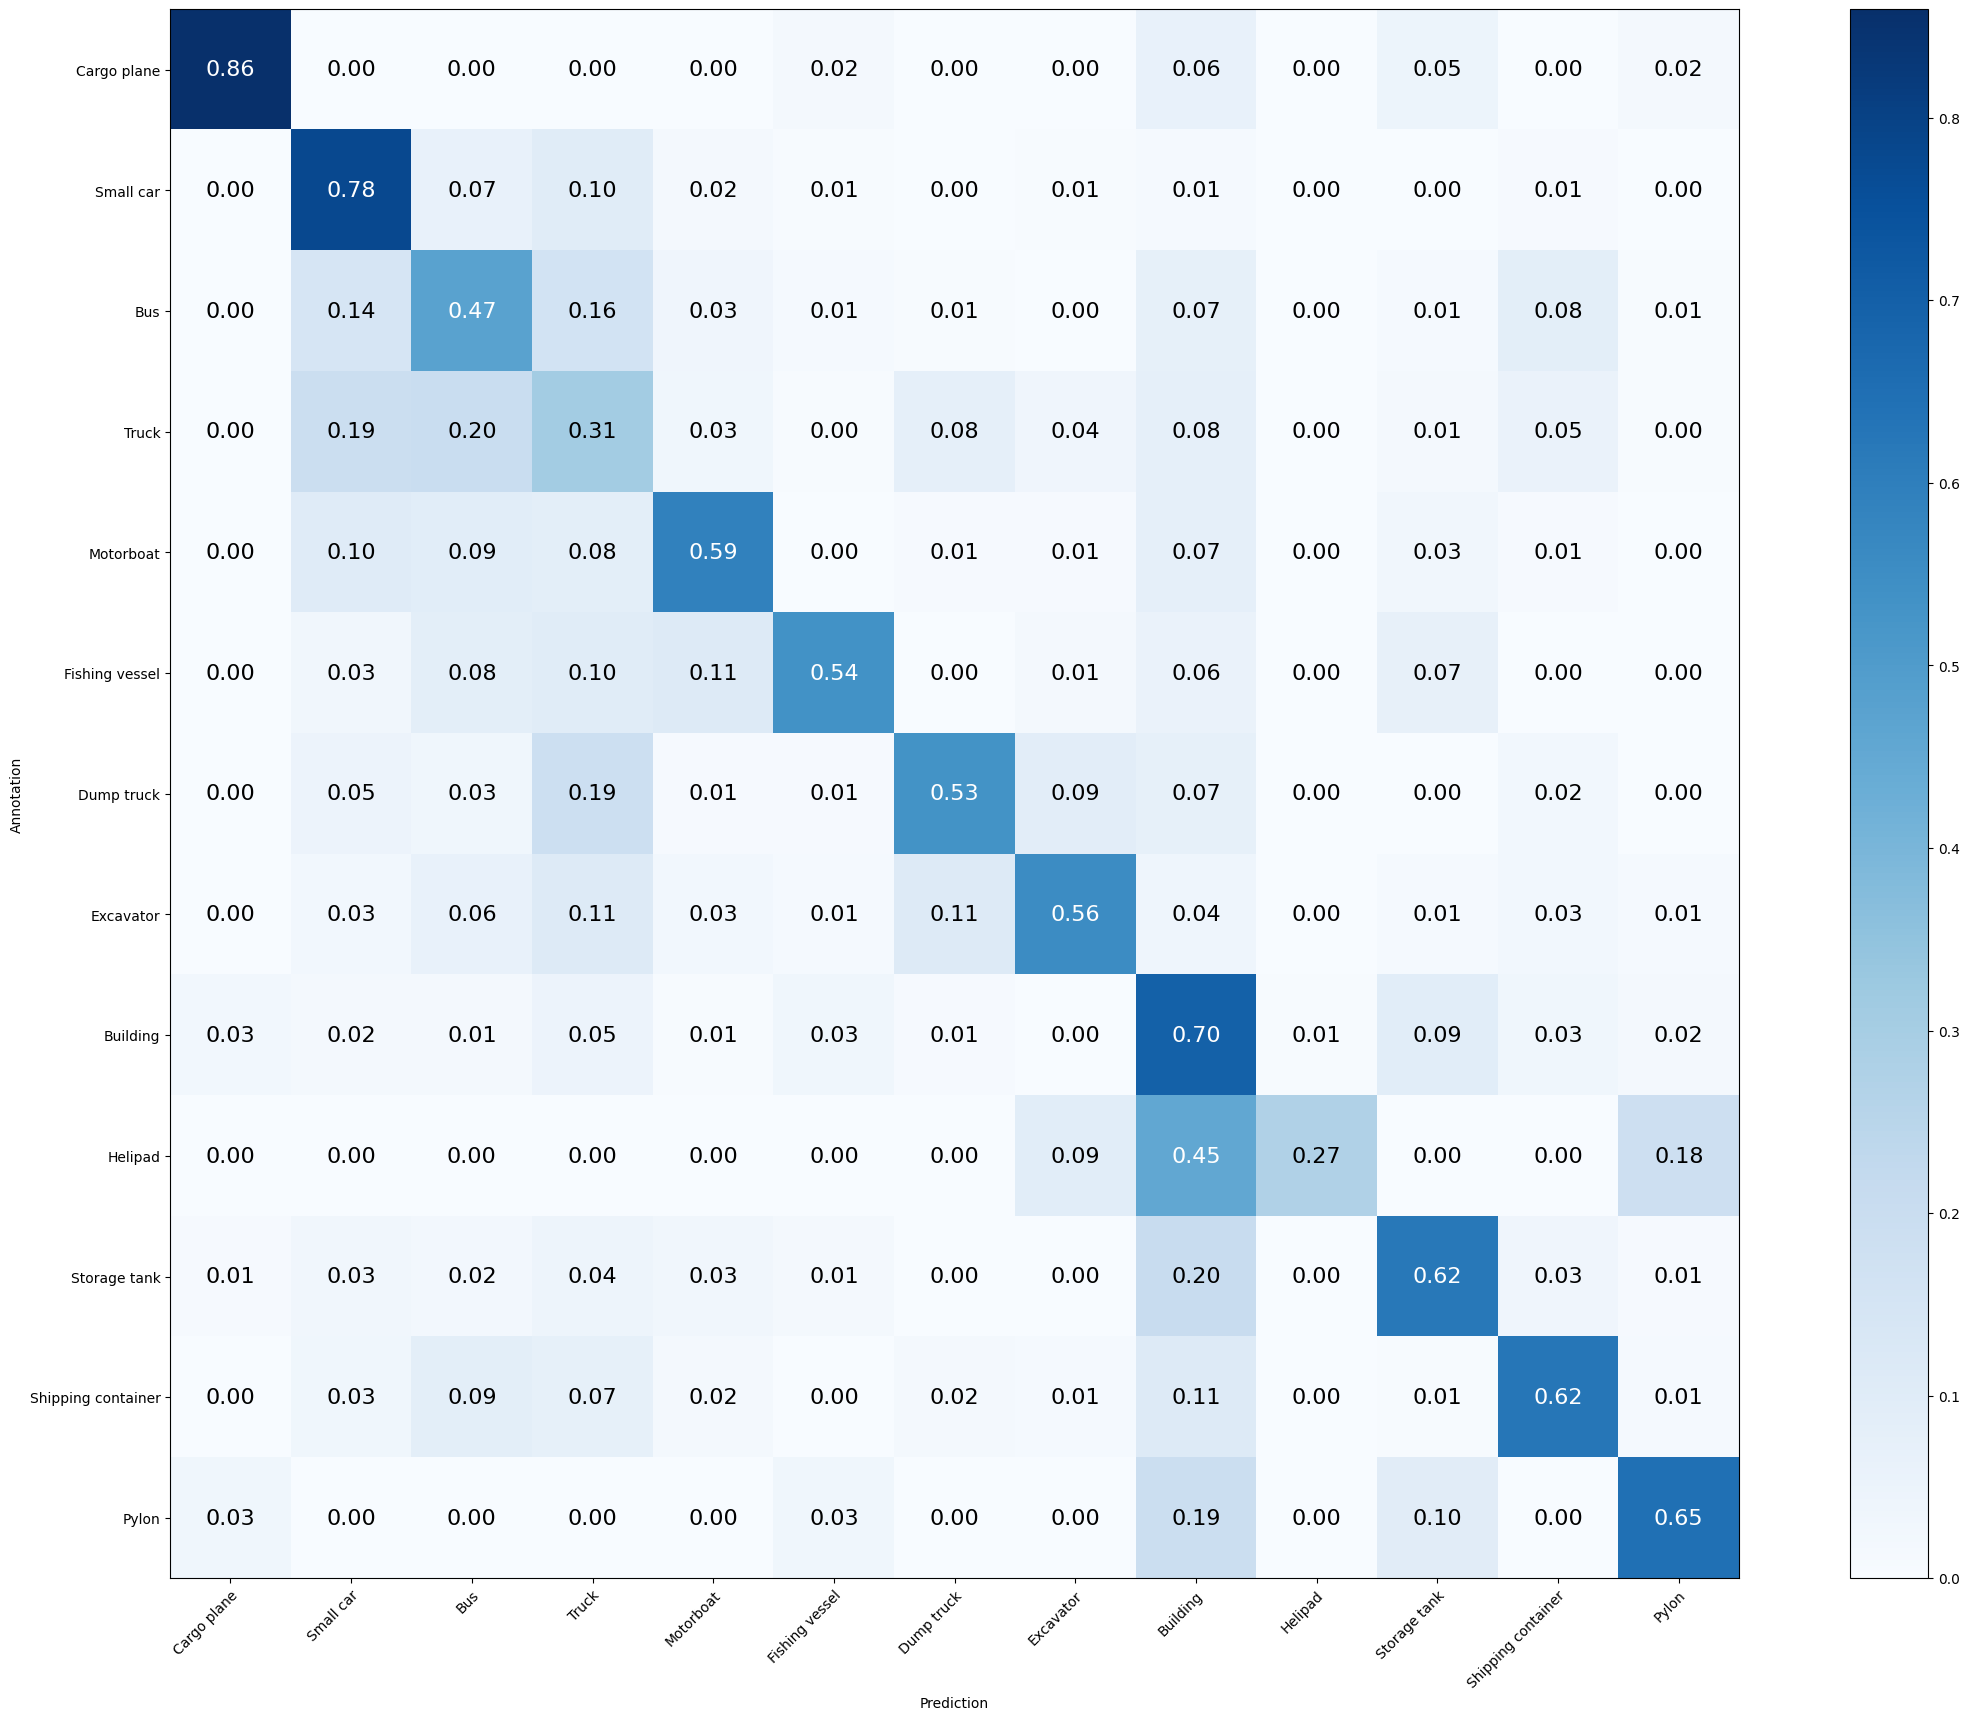

In [18]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [19]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 60.533%
Mean Recall: 57.618%
Mean Precision: 60.934%
> Cargo plane: Recall: 85.938% Precision: 83.333% Specificity: 99.393% Dice: 84.615%
> Small car: Recall: 77.711% Precision: 71.271% Specificity: 93.260% Dice: 74.352%
> Bus: Recall: 47.458% Precision: 42.857% Specificity: 93.404% Dice: 45.040%
> Truck: Recall: 30.769% Precision: 32.075% Specificity: 91.294% Dice: 31.409%
> Motorboat: Recall: 58.879% Precision: 61.765% Specificity: 97.794% Dice: 60.287%
> Fishing vessel: Recall: 53.521% Precision: 62.295% Specificity: 98.725% Dice: 57.576%
> Dump truck: Recall: 53.226% Precision: 65.347% Specificity: 98.001% Dice: 58.667%
> Excavator: Recall: 55.696% Precision: 61.972% Specificity: 98.497% Dice: 58.667%
> Building: Recall: 69.638% Precision: 67.568% Specificity: 92.084% Dice: 68.587%
> Helipad: Recall: 27.273% Precision: 60.000% Specificity: 99.893% Dice: 37.500%
> Storage tank: Recall: 61.905% Precision: 62.329% Specificity: 96.817% Dice: 62.116%
> Shipping container:

#### Testing
Try to improve the results provided in the competition.

In [20]:
import os
import numpy as np

anns = []
root_dir = './xview_recognition/'
test_dir = os.path.join(root_dir, 'xview_test')
for (dirpath, dirnames, filenames) in os.walk(test_dir):
    for filename in filenames:
        rel_dir = os.path.relpath(dirpath, root_dir)
        clean_filename = os.path.join(rel_dir, filename)
        image = GenericImage(clean_filename)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = os.path.basename(dirpath)
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

Number of testing images: 2365


In [23]:
import numpy as np
import tensorflow as tf

model.load_weights('model.keras')
predictions_data = {"images": {}, "annotations": {}}
all_test_images = []
metadata = [] # Pour stocker (image_id, bbox) dans le même ordre que les images
ann_id = 0

print("Préparation des images de test...")
for idx, ann in enumerate(anns):
    image_data = {
        "image_id": ann.filename.split('/')[-1],
        "filename": ann.filename,
        "width": int(ann.tile[2]),
        "height": int(ann.tile[3])
    }
    predictions_data["images"][idx] = image_data

    # Prétraitement (une seule fois par image source)
    image_raw = load_geoimage(ann.filename)
    image_tensor = tf.convert_to_tensor(image_raw)
    image_tensor = tf.image.convert_image_dtype(image_tensor, tf.float32)
    image_resized = tf.image.resize(image_tensor, [32,32], method='bicubic')
    img_final = image_resized.numpy()

    for obj_pred in ann.objects:
        all_test_images.append(img_final)
        metadata.append({
            "image_id": ann.filename.split('/')[-1],
            "bbox": [int(x) for x in obj_pred.bb]
        })

# Prédiction massive sur GPU
if all_test_images:
    X_test = np.array(all_test_images)
    print(f"Prédiction en cours sur {len(X_test)} détections...")

    # Utilisation du batch_size pour saturer les T4
    all_preds = model.predict(X_test, batch_size=128, verbose=1)

    category_names = list(categories.values())

    # Reconstruction du dictionnaire final
    for i, pred in enumerate(all_preds):
        pred_category = category_names[np.argmax(pred)]

        predictions_data["annotations"][ann_id] = {
            "image_id": metadata[i]["image_id"],
            "category_id": pred_category,
            "bbox": metadata[i]["bbox"]
        }
        ann_id += 1
print("Test terminé.")

Préparation des images de test...
Prédiction en cours sur 2365 détections...
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Test terminé.


In [24]:
import json
with open('prediction.json', 'w') as f:
    json.dump(predictions_data, f)